### Preparation

In [1]:
!pip install -q pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 82.0 MB/s eta 0:00:00:00:010:01


In [2]:
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, \
    TrainingArguments, Trainer
from xgboost import XGBClassifier
from datasets import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import copy
import re
import string
from pymorphy3 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

2025-05-10 11:45:05.668125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746877505.894957      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746877505.959750      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
BERT_CHECKPOINT = "ai-forever/ruRoberta-large"
PERPLEXITY_MODEL_CHECKPOINT = "openai-community/gpt2"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TMP_DIR = Path('../temp')
TMP_DIR.mkdir(exist_ok=True)

In [4]:
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_CHECKPOINT)
bert_model = AutoModel.from_pretrained(BERT_CHECKPOINT).to(DEVICE)

ppx_tokenizer = AutoTokenizer.from_pretrained(PERPLEXITY_MODEL_CHECKPOINT)
ppx_model = AutoModelForCausalLM.from_pretrained(PERPLEXITY_MODEL_CHECKPOINT).to(DEVICE)

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [5]:
def load_train_data(data_file: str, labels_file: str):
    all_texts = []
    all_labels = []

    labels_df = pd.read_csv(labels_file)
    labels_df = labels_df[labels_df["participant_index"] == 0]
    labels_dict = dict(zip(labels_df["dialog_id"], labels_df["is_bot"]))

    with open(data_file, "r", encoding="utf-8") as f:

        data = json.load(f)
        for key in data.keys():
            messages = data[key]

            part_0_texts = [
                m["text"] for m in messages if m["participant_index"] == "0"
            ]
            part_1_texts = [
                m["text"] for m in messages if m["participant_index"] == "1"
            ]

            part_0_label = int(labels_dict[key])
            part_1_label = 1 - part_0_label

            text_0 = " ".join(part_0_texts)
            text_1 = " ".join(part_1_texts)

            all_texts.append(text_0)
            all_labels.append(part_0_label)

            all_texts.append(text_1)
            all_labels.append(part_1_label)

    df = pd.DataFrame({"text": all_texts, "is_bot": all_labels})
    return df

def load_test_data(data_file: str, labels_file: str):
    df_info = pd.read_csv(labels_file)

    with open(data_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    all_texts = []
    ids = []

    for _, row in df_info.iterrows():
        dialog_id = row["dialog_id"]
        participant_index = str(row["participant_index"])
        messages = data[dialog_id]

        texts = [
            m["text"] for m in messages if m["participant_index"] == participant_index
        ]
        combined_text = " ".join(texts)
        all_texts.append(combined_text)
        ids.append(row["ID"])

    df = pd.DataFrame({"ID": ids, "text": all_texts})
    return df

In [6]:
def save_submission(name, preds, sample_submission):
    submission = copy.deepcopy(sample_submission)
    submission["is_bot"] = preds
    submission.to_csv(f"/kaggle/working/{name}.csv")

#### Bert functions

In [7]:
class CustomRoberta(nn.Module):
    def __init__(self, base_model, num_classes=2, dropout_rate=0.1):
        super().__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(self.base_model.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask=None, labels=None):
        output = self.base_model(input_ids, attention_mask = attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]
        logits = self.classifier(self.dropout(pooled_output))

        loss = None
        if labels is not None:
            loss_func = nn.CrossEntropyLoss()
            loss = loss_func(logits, labels)
            
        return {"loss": loss, "logits": logits}

def tokenize(examples, tokenizer=bert_tokenizer):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

In [8]:
def compute_metrics_bert(dataset, model):
    model.eval()
    torch_dataset = dataset.with_format("torch")
    dataloader = DataLoader(torch_dataset, batch_size=32)

    true_labels = []
    pred_labels = []
    losses = []
    with torch.no_grad():   
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            output = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = output["loss"], output["logits"]
            _, preds = torch.max(logits.cpu(), 1)
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
            losses.append(loss.cpu())
    
    model.train()
    metrics = {
        "accuracy": accuracy_score(true_labels, pred_labels),
        "f1_score": f1_score(true_labels, pred_labels),
        "loss": np.mean(losses, axis=0)
    }
    
    return metrics

In [9]:
def make_preds_bert(dataset, model):
    model.eval()
    torch_dataset = dataset.with_format("torch")
    dataloader = DataLoader(torch_dataset, batch_size=32)

    preds = []
    with torch.no_grad():   
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            output = model(input_ids, attention_mask=attention_mask)
            logits = output["logits"]

            pred_probs = torch.softmax(logits, dim=1)[:, 1]
            pred_probs = [p.item() for p in pred_probs]
            preds.extend(pred_probs)
    
    model.train()
    return preds

#### Perplexity based model functions

In [10]:
def calculate_perplexity(text, model, tokenizer):
    
    encodings = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    encodings = {k: v.to(DEVICE) for k, v in encodings.items()}

    input_ids = encodings["input_ids"]
    with torch.no_grad():
        output = model(**encodings, labels=input_ids)
        nll_loss = output["loss"].item()

    return np.exp(nll_loss)

In [11]:
def predict_with_perplexity(perplexity, threshold):
    if perplexity >= threshold:
        difference = perplexity - threshold
        
        if difference > 1000:
            return (0.8, 0.2)
        elif difference > 500:
            return (0.65, 0.35)
        elif difference > 200:
            return (0.6, 0.4)
        return (0.55, 0.45)

    difference = threshold - perplexity
        
    if difference > 1000:
        return (0.2, 0.8)
    elif difference > 500:
        return (0.35, 0.65)
    elif difference > 200:
        return (0.4, 0.6)
    return (0.45, 0.55)

In [12]:
def compute_metrics_ppx(dataframe, logits):
    true_labels = dataframe["is_bot"].values
    _, pred_labels = torch.max(logits.cpu(), 1)
    
    loss_func = nn.CrossEntropyLoss()
    loss = loss_func(logits, torch.tensor(true_labels))
    
    metrics = {
        "accuracy": accuracy_score(true_labels, pred_labels),
        "f1_score": f1_score(true_labels, pred_labels),
        "loss": loss
    }

    return metrics

#### Functions for logreg/xgbclassifier model

In [13]:
def extract_features_from_df(df_to_process, train_df):
    new_df = copy.deepcopy(df_to_process)
    
    new_df["char_len"] = new_df["text"].apply(len)
    new_df["word_len"] = new_df["text"].apply(lambda x: len(WordPunctTokenizer().tokenize(x)))
    
    emoji_pattern = re.compile(r'[:;][-]?[\)\(DP]|[\U0001F600-\U0001F64F]')
    new_df['has_emoji'] = new_df['text'].apply(lambda x: 1 if emoji_pattern.search(x) else 0)
    new_df["qu_ex_marks"] = new_df["text"].apply(lambda x: x.count("!") + x.count("?"))
    new_df["punct_count"] = new_df["text"].apply(
        lambda x: sum([1 for ch in x if ch in string.punctuation])
    )
    new_df["upper_char_ratio"] = new_df["text"].apply(
        lambda x: sum([1 for ch in x if ch.isupper()]) / max(1, len(x))
    )

    morph = MorphAnalyzer()
    def lemmatize(text):
        total = []
        words = WordPunctTokenizer().tokenize(text.lower())
        for word in words:
            total.append(morph.parse(word)[0].normal_form)
        return " ".join(total)
        
    new_df["lemmatized"] = new_df["text"].apply(lemmatize)

    new_df["unique_word_ratio"] = new_df["lemmatized"].apply(
        lambda x: len(set(x.split())) / max(1, len(x.split()))
    )
    
    stopwords_set = set(stopwords.words("russian"))
    stopwords_set.update(stopwords.words("english"))
    new_df["stopword_ratio"] = new_df["lemmatized"].apply(
        lambda x: len([w for w in x.split() if w in stopwords_set]) / max(1, len(x.split()))
    )

    train_df_with_lemmatized = copy.deepcopy(train_df)
    train_df_with_lemmatized["lemmatized"] = train_df_with_lemmatized["text"].apply(lemmatize)
    all_words = [
        word.lower()
        for text in train_df_with_lemmatized["lemmatized"]
        for word in WordPunctTokenizer().tokenize(text.lower())
    ]
    word_freq = Counter(all_words)
    top_100_words = set(word for word, _ in word_freq.most_common(100))
    new_df["rare_word_freq"] = new_df["lemmatized"].apply(
        lambda x: len([w for w in x.split() if w not in top_100_words]) / max(1, len(x.split()))
    )

    tfidf = TfidfVectorizer(max_features=1000)
    tfidf = tfidf.fit(train_df_with_lemmatized["lemmatized"])
    sparse_matrix = tfidf.transform(new_df["lemmatized"])
    new_df["tf_idf_mean"] = sparse_matrix.sum(axis=1) / sparse_matrix.shape[1]

    return new_df

In [14]:
def compute_metrics_logreg(X, y, model):
    logits = torch.tensor(model.predict_proba(X))
    _, pred_labels = torch.max(logits, axis=1)

    loss_func = nn.CrossEntropyLoss()
    loss = loss_func(logits, torch.tensor(y.values))
    
    metrics = {
        "accuracy": accuracy_score(y.values, pred_labels),
        "f1_score": f1_score(y.values, pred_labels),
        "loss": loss
    }

    return metrics

In [15]:
def make_preds_logreg(X, model):
    preds = xgb_model.predict_proba(X)[:,1]
    return preds

#### Ensemble of models (Weighted Averaging) functions

In [16]:
def predict_with_3_models(bert, ppx_threshold, ppx_model, ppx_tokenizer,
                          logreg, test_df, test_dataset, train_df):    
    bert_preds = make_preds_bert(test_dataset, bert)
    
    ppx_preds = []
    test_ppx = [] # Сохраним значения perplexity для след. модели
    for i in test_data.index:
        text = test_data.iloc[i]["text"]
        ppx = calculate_perplexity(text, ppx_model, ppx_tokenizer)
        test_ppx.append(ppx)
        ppx_preds.append(predict_with_perplexity(ppx, ppx_threshold)[1])
        
    test_df_with_perplexity = copy.deepcopy(test_df)
    test_df_with_perplexity["perplexity"] = test_ppx

    new_test_data = extract_features_from_df(test_df_with_perplexity, train_df)
    X_test = new_test_data.drop(columns=["ID", "text", "lemmatized"])
    xgb_preds = make_preds_logreg(X_test, xgb_model)
    
    ensemble_preds = []
    for i in range(len(bert_preds)):
        ensemble_pred = bert_preds[i] * 0.7 + ppx_preds[i] * 0.1 + xgb_preds[i] * 0.2
        ensemble_preds.append(ensemble_pred)

    return ensemble_preds    

In [41]:
def predict_with_2_models(bert, logreg, test_df, test_dataset, train_df):    
    bert_preds = make_preds_bert(test_dataset, bert)
    
    test_ppx = [] # Сохраним значения perplexity для след. модели
    for i in test_data.index:
        text = test_data.iloc[i]["text"]
        ppx = calculate_perplexity(text, ppx_model, ppx_tokenizer)
        test_ppx.append(ppx)
        
    test_df_with_perplexity = copy.deepcopy(test_df)
    test_df_with_perplexity["perplexity"] = test_ppx

    new_test_data = extract_features_from_df(test_df_with_perplexity, train_df)
    X_test = new_test_data.drop(columns=["ID", "text", "lemmatized"])
    xgb_preds = make_preds_logreg(X_test, xgb_model)
    
    ensemble_preds = []
    for i in range(len(bert_preds)):
        ensemble_pred = bert_preds[i] * 0.6 + xgb_preds[i] * 0.4
        ensemble_preds.append(ensemble_pred)

    return ensemble_preds    

#### Data load

In [18]:
train_data = load_train_data("/kaggle/input/you-are-bot/train.json", "/kaggle/input/you-are-bot/ytrain.csv")
test_data = load_test_data("/kaggle/input/you-are-bot/test.json", "/kaggle/input/you-are-bot/ytest.csv")
sample_submission = pd.read_csv("/kaggle/input/you-are-bot/sample_submission.csv", index_col="ID")

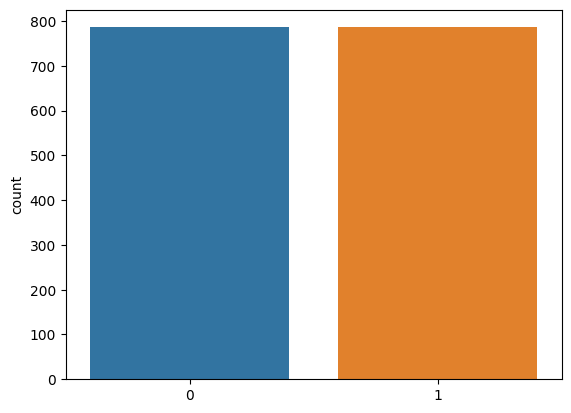

In [19]:
sns.barplot(x = train_data["is_bot"].unique(), y = train_data["is_bot"].value_counts())
plt.show()

In [20]:
train_df, val_df = train_test_split(train_data, test_size=0.15)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Убираем ненужную колонку
train_dataset = train_dataset.remove_columns(["__index_level_0__"])
val_dataset = val_dataset.remove_columns(["__index_level_0__"])

# Переименовываем таргетную колонку
train_dataset = train_dataset.rename_column("is_bot", "labels")
val_dataset = val_dataset.rename_column("is_bot", "labels")

# Токенизируем датасет
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/1336 [00:00<?, ? examples/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

In [21]:
test_dataset = Dataset.from_pandas(test_data)
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/676 [00:00<?, ? examples/s]

### BERT MODEL

In [22]:
roberta = CustomRoberta(bert_model)
roberta = roberta.to(DEVICE)

In [24]:
training_args = TrainingArguments(
    output_dir= TMP_DIR,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    logging_strategy="epoch", 
    eval_strategy="epoch",
    save_strategy="epoch",
    greater_is_better=False,       
    report_to="none",
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model=roberta,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.728700,0.654030
2,0.652600,0.636998
3,0.553600,0.687069
4,0.488500,0.675319
5,0.411100,0.677855


TrainOutput(global_step=420, training_loss=0.5669084912254697, metrics={'train_runtime': 1229.6658, 'train_samples_per_second': 5.432, 'train_steps_per_second': 0.342, 'total_flos': 0.0, 'train_loss': 0.5669084912254697, 'epoch': 5.0})

In [26]:
print(compute_metrics_bert(val_dataset, roberta))

100%|██████████| 8/8 [00:22<00:00,  2.85s/it]

{'accuracy': 0.6228813559322034, 'f1_score': 0.642570281124498, 'loss': 0.6309968}


In [27]:
bert_preds = make_preds_bert(test_dataset, roberta)
save_submission("submission_bert", bert_preds, sample_submission)

100%|██████████| 22/22 [01:05<00:00,  2.98s/it]


### PERPLEXITY BASED MODEL

In [28]:
perplexities = []
for i in tqdm(train_df.index):
    text = train_df.loc[i]["text"]
    ppx = calculate_perplexity(text, ppx_model, ppx_tokenizer)
    perplexities.append(ppx)

train_df["perplexity"] = perplexities

perplexities = []
for i in tqdm(val_df.index):
    text = val_df.loc[i]["text"]
    ppx = calculate_perplexity(text, ppx_model, ppx_tokenizer)
    perplexities.append(ppx)

val_df["perplexity"] = perplexities

100%|██████████| 236/236 [00:03<00:00, 76.19it/s]


In [29]:
perplexities = train_df["perplexity"].values
labels = train_df["is_bot"].values

thresholds = np.sort(perplexities)

best_thershold = None
best_f1 = 0

for threshold in thresholds:
    preds = (perplexities < threshold).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"f1_score for train data: {best_f1}, threshold: {best_threshold}")

f1_score for train data: 0.664321608040201, threshold: 1915.7841755787535


In [30]:
logits = []
for i in val_df.index:
    cur_logit = predict_with_perplexity(val_df.loc[i]["perplexity"], best_threshold)
    logits.append(cur_logit)

print(compute_metrics_ppx(val_df, torch.tensor(logits)))

{'accuracy': 0.5169491525423728, 'f1_score': 0.6779661016949153, 'loss': tensor(0.7299)}


In [32]:
ppx_preds = []
test_ppx = [] # Сохраним значения perplexity для след. модели

for i in test_data.index:
    text = test_data.iloc[i]["text"]
    ppx = calculate_perplexity(text, ppx_model, ppx_tokenizer)
    test_ppx.append(ppx)
    ppx_preds.append(predict_with_perplexity(ppx, best_threshold)[1])

test_data["perplexity"] = test_ppx

save_submission("submission_ppx", ppx_preds, sample_submission)

### LogisticRegression and XGBClassifier on features

In [33]:
new_train_df = extract_features_from_df(train_df, train_df)
new_val_df = extract_features_from_df(val_df, train_df)

X_train = new_train_df.drop(columns=["text", "is_bot", "lemmatized"])
y_train = new_train_df["is_bot"]

X_val = new_val_df.drop(columns=["text", "is_bot", "lemmatized"])
y_val = new_val_df["is_bot"]

In [34]:
log_reg_model = LogisticRegression().fit(X_train, y_train)

In [35]:
print(compute_metrics_logreg(X_val, y_val, log_reg_model))

{'accuracy': 0.5889830508474576, 'f1_score': 0.5125628140703516, 'loss': tensor(0.6833, dtype=torch.float64)}


In [36]:
xgb_model = XGBClassifier(
    n_estimators=100,  
    max_depth=3,       
    learning_rate=0.1, 
    eval_metric="logloss", 
    early_stopping_rounds=10,  
    use_label_encoder=False,
).fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-logloss:0.68714
[1]	validation_0-logloss:0.68178
[2]	validation_0-logloss:0.67795
[3]	validation_0-logloss:0.67586
[4]	validation_0-logloss:0.67297
[5]	validation_0-logloss:0.66993
[6]	validation_0-logloss:0.66842
[7]	validation_0-logloss:0.66642
[8]	validation_0-logloss:0.66568
[9]	validation_0-logloss:0.66405
[10]	validation_0-logloss:0.66381
[11]	validation_0-logloss:0.66353
[12]	validation_0-logloss:0.66322
[13]	validation_0-logloss:0.66356
[14]	validation_0-logloss:0.66334
[15]	validation_0-logloss:0.66089
[16]	validation_0-logloss:0.66100
[17]	validation_0-logloss:0.65745
[18]	validation_0-logloss:0.65904
[19]	validation_0-logloss:0.65786
[20]	validation_0-logloss:0.65756
[21]	validation_0-logloss:0.65816
[22]	validation_0-logloss:0.65639
[23]	validation_0-logloss:0.65746
[24]	validation_0-logloss:0.65923
[25]	validation_0-logloss:0.66079
[26]	validation_0-logloss:0.66090
[27]	validation_0-logloss:0.66257
[28]	validation_0-logloss:0.66392
[29]	validation_0-loglos

In [37]:
print(compute_metrics_logreg(X_val, y_val, xgb_model))

{'accuracy': 0.614406779661017, 'f1_score': 0.5284974093264247, 'loss': tensor(0.6659)}


XGBClassifier показал лучше качество, чем LogisticRegression, поэтому будем использовать его

In [38]:
new_test_data = extract_features_from_df(test_data, train_df)
X_test = new_test_data.drop(columns=["ID", "text", "lemmatized"])

xgb_preds = make_preds_logreg(X_test, xgb_model)
save_submission("submission_xgb", xgb_preds, sample_submission)

### Ensemble of models (Weighted Averaging)

In [39]:
ensemble_3_models_preds = predict_with_3_models(roberta, best_threshold, ppx_model,
                                                ppx_tokenizer, xgb_model,
                                                test_data, test_dataset, train_df)
save_submission("submission_ensemble_3_models_preds",
                ensemble_3_models_preds, sample_submission)

100%|██████████| 22/22 [01:06<00:00,  3.00s/it]


In [42]:
ensemble_2_models_preds = predict_with_2_models(roberta, xgb_model,
                                                test_data, test_dataset, train_df)
save_submission("submission_ensemble_2_models_preds",
                ensemble_2_models_preds, sample_submission)

100%|██████████| 22/22 [01:05<00:00,  2.99s/it]


### Conclusion

В ходе работы было протестировано 5 подходов: fine-tuning ruRoberta, perplexity-based подход, XGBclassifier на вытащенных фичах, а также ансамбль из этих 3 моделей и ансамбль из ruRoberta и XGBClassifier

- ruRoberta: самый стандартный подход, дообучить BERT. Получился неплохой, но и не хороший результат. Качество лучше бэйзлайна, но не намного
- perplexity-based: пороговый детектор на основе перплексии, которую считала модель GPT2 оказался худшим подходом из всех. Это неудивительно, потому что данные специфичные, и бот выдает много странных вещей. Следовательно, самое низкое качество
- XGBClassifier: немного обогнал ruRoberta. С помощью вытащенных фичей модель научилась выделять закономерности, но, опять же, качество не самое великолепное
- Ансамбль из 3 моделей: добился такого же результата, как и чистый XGBClassifier. Но, учитывая, насколько бесполезный пороговый детектор, смысла от этой модели в ансамбле мало
- Ансамбль из ruRoberta и XGBClassifier: лучшее качество из всех опробованных подходов. Путем взвешенного усреднения (предсказание BERT * 0.6 + предсказание XGBClassifier * 0.4) ансамбль моделей смог учитывай большее количество информации, чем модели по отдельности. LogLoss на тестовой выборке = 0.587